In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from dolfin import * 
import math
from IPython.display import clear_output
from time import sleep
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)

# Experiment setup

In [3]:
from math import exp
import numpy as np
from functools import partial

def prior(x, sigma=1.):
    return np.exp(-0.5*np.log(x)**2/sigma**2).prod()

def likelihood(x, F, d_obs, sigma):
    return math.exp(-np.linalg.norm(F - d_obs)**2/sigma)

# F, d flatten
def posterior(x, F, d_obs, prior, sigma):
    return likelihood(x, F, d_obs, sigma)*prior(x)

# F, F_m flatten    
def t_cond(F, F_m, sigma):
    return np.linalg.norm((F - F_m)/sigma, np.inf)

def normal_sampler(x, sigma=.1):
    return np.random.multivariate_normal(x, np.diag([sigma]*len(x))) 

def metropolis_step(x, pi, q):
    new_x = q(x)
    alpha = min(1, pi(new_x)/(pi(x) + 1e-4))
#     print(new_x, x, pi(new_x), pi(x))
    if np.random.uniform() < alpha:
        return new_x, True, alpha
    else:
        return new_x, False, alpha
    
q = partial(normal_sampler, sigma=.1)

In [4]:
task = TaskSetup(2, 30, n_p=9, seed=44)
task.x, task.ri
# task.L[:600,1000:] = np.zeros((600, 600))

(array([0.09377863, 3.35647676, 0.14907569, 2.05795366, 8.34131195,
        0.791121  , 5.21390816, 0.08895478, 0.0924574 ]),
 array([[0.83484215, 0.1047961 ],
        [0.74464048, 0.36050084],
        [0.35931084, 0.60923838],
        [0.39377955, 0.40907261],
        [0.50990241, 0.71014799],
        [0.96052623, 0.45662111],
        [0.42765152, 0.1134637 ],
        [0.21789887, 0.95747207],
        [0.94335072, 0.88182428]]))

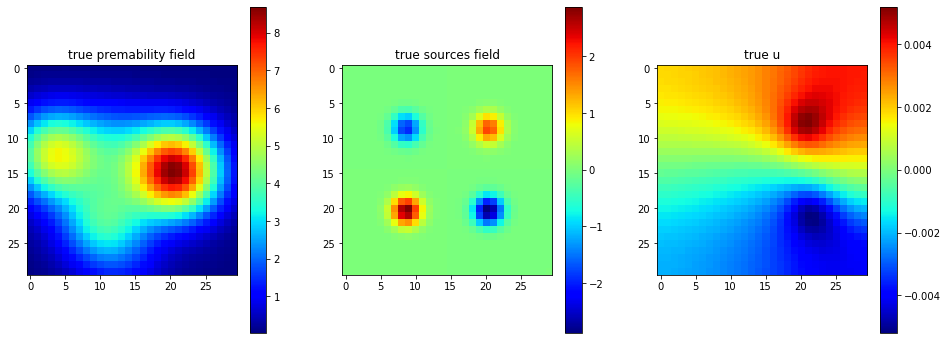

In [5]:
plt.rcParams['figure.figsize'] = (16,6)
plt.subplot(131); plt.imshow(task.K, cmap='jet'); plt.title('true premability field'); plt.colorbar()
plt.subplot(132); plt.imshow(task.Q, cmap='jet'); plt.title('true sources field'); plt.colorbar()
plt.subplot(133); plt.imshow(task.u, cmap='jet'); plt.title('true u'); plt.colorbar()
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 12))
# ax1.imshow(task.K); ax1.set_title('true premability field')
# ax2.imshow(task.Q); ax2.set_title('true sources field')
# ax3.imshow(task.u); ax3.set_title('true u')

# Ordinary metropolis


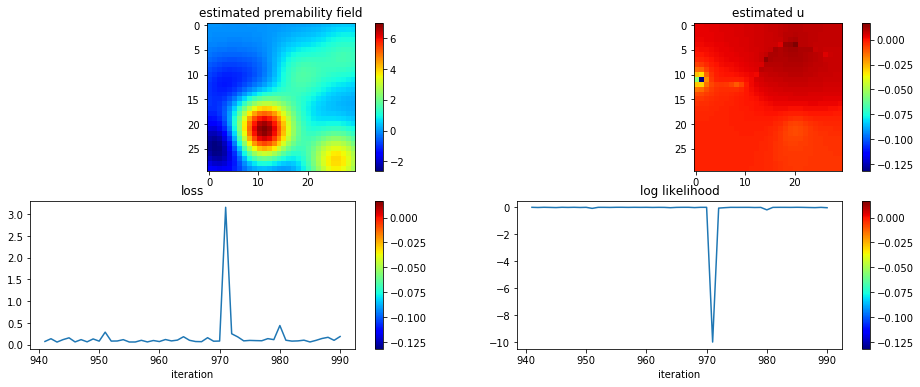

iter: 991
u_loss: 0.18899833067657903, x_loss: 13.419132308809985
average acceptance level: 0.978836368178014
cummulative_time: 289.53310400000055
last x: [-3.56433883  8.07063193  1.86238489 -0.87444606 -0.06433257 -1.32793486
 -1.1904409   1.44267292  3.95770462]
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [7]:
x_loss = []
u_loss = []
x_i = []
times = [] # appended on each iteration, regardless the acceptance
acceptance_betas = []
log_likelihoods = []

sigma0 = 2
sigma_d = 1.
x = np.random.lognormal(mean=.0, sigma=sigma0, size=task.n_p)
x_i.append(x)
q = partial(normal_sampler, sigma=0.005)
N_maxiter = 1000
N_verbose = 10

u_last, _ = task.evaluate(x) 
time = 0
for i in range(N_maxiter):
    x_new = q(x)
    u, dt = task.evaluate(x_new)
    time += dt
    pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
    beta = min(1, pi(x_new)/(pi(x) + 1e-5))
    if np.random.uniform() < beta:
        acceptance_betas.append(beta)
        x = x_new
        u_last = u
    x_i.append(x)
    log_likelihoods.append(np.log(likelihood(x, u_last, task.u, sigma_d)))
        
    x_loss.append(np.linalg.norm(task.x - x_i[-1]))
    u_loss.append(np.linalg.norm(task.u - u_last))
    times.append(time)

    K = task.eval_perm_field(x)
    
    with open('OMG_log.pkl', 'wb') as f:
        pickle.dump({
            'x_loss': x_loss,
            'u_loss': u_loss,
            'x_i': x_i,
            'times': times,
            'acceptance_betas': acceptance_betas,
            'log_likelihoods': log_likelihoods
        }, f)

    if i % N_verbose == 0:
        clear_output()
        plt.rcParams['figure.figsize'] = (16,6)
        plt.subplot(221); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
        plt.subplot(222); plt.imshow(u_last, cmap='jet'); plt.title('estimated u'); plt.colorbar()
        lastN = 50
        plt.subplot(223); plt.plot(np.arange(max(i-lastN+1, 0), i+1), u_loss[-lastN:]); plt.title('loss'); plt.xlabel('iteration'); plt.colorbar()
        plt.subplot(224); plt.plot(np.arange(max(i-lastN+1, 0), i+1), log_likelihoods[-lastN:]); plt.title('log likelihood'); plt.xlabel('iteration'); plt.colorbar()
        plt.show()
        print(f'iter: {i+1}')
        print(f'u_loss: {u_loss[-1]}, x_loss: {x_loss[-1]}')
        print(f'average acceptance level: {np.mean(acceptance_betas)}')
        print(f'cummulative_time: {times[-1]}')
        print(f'last x: {x_i[-1]}')
        print('-'*40)

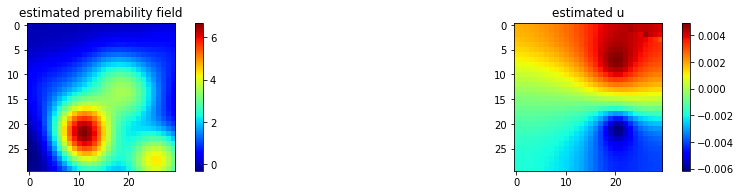

best iter: 440
u_loss: 0.011059633141127716, x_loss: 9.44183063142586
cummulative_time: 127.79390500000012


In [22]:
ind_best = np.argmax(log_likelihoods)
# ind_best = np.argmin(u_loss)
x_best = x_i[ind_best]
K = task.eval_perm_field(x_best) 
u, _ = task.evaluate(x_best)
plt.subplot(221); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
plt.subplot(222); plt.imshow(u, cmap='jet'); plt.title('estimated u'); plt.colorbar()
plt.show()
print(f'best iter: {ind_best + 1}')
print(f'u_loss: {u_loss[ind_best]}, x_loss: {x_loss[ind_best]}')
print(f'cummulative_time: {times[ind_best]}')

# alg1

In [16]:
class alg1:
    def __init__(self, from_log=False, eps=1e-3):
        self.x_loss = []
        self.u_loss = []
        self.x_i = []
        self.times = [] # appended on each iteration, regardless the acceptance
        self.acceptance_betas = []
        self.log_likelihoods = []
        self.n_steps = []
        self.error_rows = []
        self.n_basis = []
        
        if from_log:
            with open(f'alg1_eps{eps:.4f}_log.pkl', 'rb') as f:
                data = pickle.load(f)
                self.x_loss = data['x_loss'] 
                self.u_loss = data['u_loss'] 
                self.x_i = data['x_i'] 
                self.times = data['times'] # appended on each iteration, regardless the acceptance
                self.acceptance_betas = data['acceptance_betas'] 
                self.log_likelihoods = data['log_likelihoods'] 
                self.n_steps = data['n_steps'] 
                self.n_basis = data['n_basis'] 
    
    def __call__(self, task=task, sigma0=2, sigma_d=1., eps=1e-3, x=None, N_maxiter=100, L=50, c=1e-1, N_verbose=1):
        self.x_loss = []
        self.u_loss = []
        self.x_i = []
        self.times = [] # appended on each iteration, regardless the acceptance
        self.acceptance_betas = []
        self.log_likelihoods = []
        self.n_steps = []
        self.error_rows = []
        self.n_basis = []
        
        if x is None:
            x = np.random.lognormal(mean=.0, sigma=sigma0, size=task.n_p)
        q = partial(normal_sampler, sigma=0.01)

        snapshots = []
        time = 0
        u_last, _ = task.evaluate(x)
        for i in range(N_maxiter):
            x_new = None
            stop = 0
            t = 0
            if len(snapshots) > 2:
                error_row = []
                y = x.copy()
                for j in range(L):
                    u, _ = task.evaluate(y)
                    u_m, dt = task.basis_projection_solution(y, snapshots, u, True)
                    time += dt

                    t = t_cond(u_m, u, sigma_d)
                    error_row.append(t)
                    if t > eps and j > 0 and len(self.n_steps) > 0 and np.mean(self.n_steps) > 1/c/eps:
                        error_rows.append(error_row) 
                        n_steps.append(j)
                        stop = j
                        break
                    pi = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
                    y_new, res, _ = metropolis_step(y, pi, q)
                    if res:
                        y = y_new
                    if j == L-1:
                        self.n_steps.append(j)
                        stop = j
                x_new = y.copy()
            if x_new is None:
                x_new = q(x)
            u, dt = task.evaluate(x_new)
            time += dt
            pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
            alpha = min(1, pi(x_new)/(pi(x) + 1e-4))
            if np.random.uniform() < alpha:
                self.acceptance_betas.append(alpha)
                x = x_new
                u_last = u
                if len(snapshots) > 2:
                    u_m, dt = task.basis_projection_solution(x, snapshots, u, True)
                    t = t_cond(u_m, task.u, sigma_d)
                else:
                    t = 2*eps
                if  t > eps:
                    snapshots.append(u)

            self.x_i.append(x)
            self.n_basis.append(len(snapshots))
            self.x_loss.append(np.linalg.norm(task.x - self.x_i[-1]))
            self.u_loss.append(np.linalg.norm(task.u - u_last))
            self.log_likelihoods.append(np.log(likelihood(x, u_last, task.u, sigma_d)))
            self.times.append(time)
            self.n_steps.append(stop + 1)

            K = task.eval_perm_field(x)

            with open(f'alg1_eps{eps:.4f}_log.pkl', 'wb') as f:
                pickle.dump({
                    'x_loss': self.x_loss,
                    'u_loss': self.u_loss,
                    'x_i': self.x_i,
                    'times': self.times,
                    'acceptance_betas': self.acceptance_betas,
                    'log_likelihoods': self.log_likelihoods,
                    'n_basis': self.n_basis,
                    'n_steps': self.n_steps,
                }, f)

            if i % N_verbose == 0:
                clear_output()
                plt.rcParams['figure.figsize'] = (16,6)
                plt.subplot(231); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
                plt.subplot(232); plt.imshow(u_last, cmap='jet'); plt.title('estimated u'); plt.colorbar()
                lastN = 50
                plt.subplot(233); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.u_loss[-lastN:]); plt.title('loss'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(234); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.log_likelihoods[-lastN:]); plt.title('log likelihood'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(235); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.times[-lastN:]); plt.title('time'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(236); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.n_basis[-lastN:]); plt.title('basis size'); plt.xlabel('iteration'); plt.colorbar()
                plt.show()
                print(f'iter: {i+1}')
                print(f'u_loss: {self.u_loss[-1]}, x_loss: {self.x_loss[-1]}')
                print(f'average acceptance level: {np.mean(self.acceptance_betas)}')
                print(f'basis size: {self.n_basis[-1]}')
                print(f'cummulative_time: {self.times[-1]}')
                print(f'last x: {self.x_i[-1]}')
                print('-'*40)
                
    def print_best(self):
        ind_best = np.argmax(self.log_likelihoods)
        x_best = self.x_i[ind_best]
        K = task.eval_perm_field(x_best) 
        u, _ = task.evaluate(x_best)
        plt.subplot(221); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
        plt.subplot(222); plt.imshow(u, cmap='jet'); plt.title('estimated u'); plt.colorbar()
        plt.show()
        print(f'best iter: {ind_best + 1}')
        print(f'average acceptance level: {np.mean(self.acceptance_betas)}')
        print(f'basis size: {self.n_basis[ind_best]}')
        print(f'u_loss: {self.u_loss[ind_best]}, x_loss: {self.x_loss[ind_best]}')
        print(f'cummulative_time: {self.times[ind_best]}')

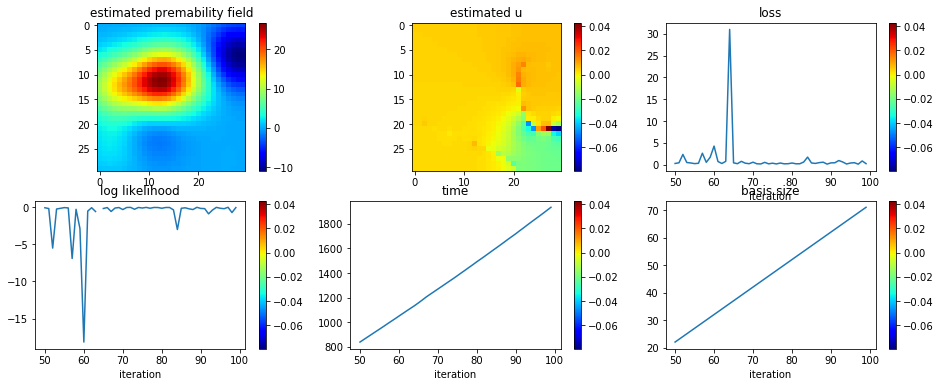

iter: 100
u_loss: 0.2337369252098583, x_loss: 27.464368981297014
average acceptance level: 0.9752640132144397
basis size: 71
cummulative_time: 1934.4538959999536
last x: [  2.6084298   -2.90462799   8.2076784   22.09272174   0.14286912
  -0.10347177  11.88680379 -11.30795246   0.13557089]
----------------------------------------


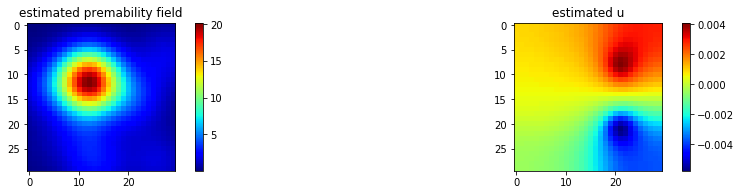

best iter: 19
average acceptance level: 0.9752640132144397
basis size: 3
u_loss: 0.030348776235631824, x_loss: 18.77366473894105
cummulative_time: 212.81998699999895


In [20]:
alg = alg1()
alg(eps=1e-1, N_verbose=3)
alg.print_best()

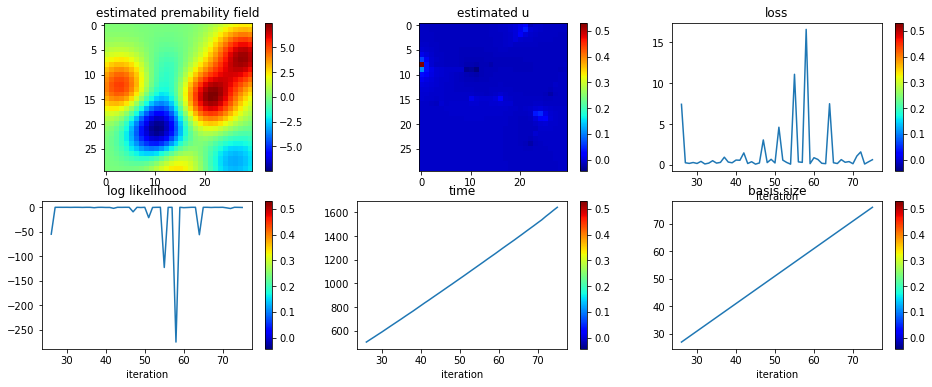

iter: 76
u_loss: 0.6258041515970731, x_loss: 15.379784531330003
average acceptance level: 1.0
basis size: 76
cummulative_time: 1641.8514000000432
last x: [ 0.21949369 -8.75482861 -0.04225354 -2.49456746  7.57197337  4.20655296
  5.67974137  6.8491417  -3.20936171]
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) com

KeyboardInterrupt: 

In [23]:
alg = alg1()
alg(eps=1e-2, N_verbose=3)
alg.print_best()

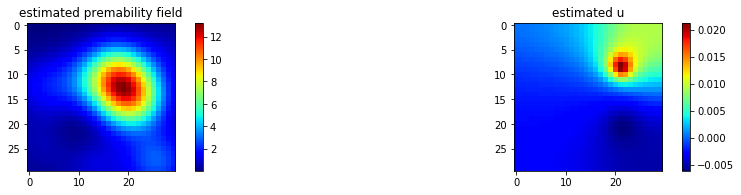

best iter: 7
average acceptance level: 1.0
basis size: 6
u_loss: 0.08258732471719583, x_loss: 9.282672842091138
cummulative_time: 56.86797700000352


In [12]:
alg = alg1()
alg(eps=1e-3, N_verbose=3)
alg.print_best()

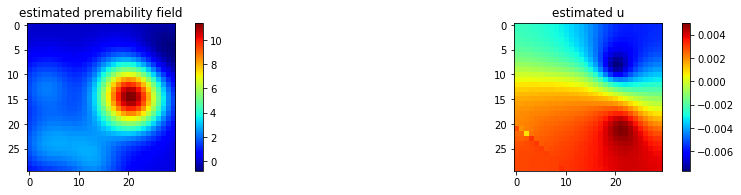

best iter: 7
average acceptance level: 0.9984134444885403
basis size: 3
u_loss: 0.027851356771326583, x_loss: 5.818393728825889
cummulative_time: 15.64289699999998


In [17]:
alg = alg1(True, 1e-1)
alg.print_best()

# alg2 v2

In [10]:
class alg2:
    def __init__(self, from_log=False, eps=1e-3):
        self.x_loss = []
        self.u_loss = []
        self.x_i = []
        self.times = [] # appended on each iteration, regardless the acceptance
        self.acceptance_betas = []
        self.log_likelihoods = []
        self.n_steps = []
        self.error_rows = []
        self.n_basis = []
        self.full_evals = []
        
        if from_log:
            with open(f'alg2_eps{eps:.4f}_log.pkl', 'rb') as f:
                data = pickle.load(f)
                self.x_loss = data['x_loss'] 
                self.u_loss = data['u_loss'] 
                self.x_i = data['x_i'] 
                self.times = data['times'] # appended on each iteration, regardless the acceptance
                self.acceptance_betas = data['acceptance_betas'] 
                self.log_likelihoods = data['log_likelihoods'] 
                self.n_steps = data['n_steps'] 
                self.n_basis = data['n_basis'] 
                self.full_evals = data['full_evals']
    
    def __call__(self, task=task, sigma0=2, sigma_d=1., eps=1e-3, x=None, N_maxiter=100, L=50, c=1e-1, N_verbose=1):
        self.x_loss = []
        self.u_loss = []
        self.x_i = []
        self.times = [] # appended on each iteration, regardless the acceptance
        self.acceptance_betas = []
        self.log_likelihoods = []
        self.n_steps = []
        self.error_rows = []
        self.n_basis = []
        
        eps0=eps*10
        len_min=2
        
        if x is None:
            x = np.random.lognormal(mean=.0, sigma=sigma0, size=task.n_p)
        q = partial(normal_sampler, sigma=0.005)

        full_counter = 0
        snapshots = []
        error_rows = []
        time = 0
        u_last, _ = task.evaluate(x)
        for i in range(N_maxiter):
            x_new = None
            stop = 0
            t = 0
            if len(snapshots) > len_min:
                error_row = []
                y = x.copy()
                for j in range(L):
                    u, _ = task.evaluate(y)
                    u_m, dt = task.basis_projection_solution(y, snapshots, u)
                    time += dt
                    t = t_cond(u_m, u, sigma_d)
        #             error_row.append(t)
                    if t > eps and j > 0 and len(self.n_steps) > 0 and np.mean(self.n_steps) > 1/c/eps:
        #                 error_rows.append(error_row)
                        n_steps.append(j)
                        stop = j
                        break
                    pi = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
                    y_new, res, _ = metropolis_step(y, pi, q)
                    if res:
                        y = y_new
                    if j == L-1:
                        self.n_steps.append(j)
                        stop = j
                x_new = y.copy()

            if x_new is None:
                x_new = q(x)
            u, dt1 = task.evaluate(x_new)
            if len(snapshots) > len_min:
                u_m, dt2 = task.basis_projection_solution(y, snapshots, u)
                t_m = t_cond(task.u, u_m, sigma_d)
            if len(snapshots) <= len_min or t_m > eps0:
                time += dt1
                full_counter += 1
                pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
                beta = min(1, pi(x_new)/(pi(x) + 1e-10))
                if np.random.rand() < beta:
                    self.acceptance_betas.append(beta)
                    x = x_new
                    snapshots.append(u)
                    u_last = u
            elif t_m > eps:
                time += dt2
                pi_m = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
                beta = min(1, pi_m(x_new)/(pi_m(x) + 1e-10))
                if np.random.rand() < beta:
                    time += dt1
                    full_counter += 1
                    pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
                    beta = min(1, pi(x_new)/(pi(x) + 1e-10))
                    if np.random.rand() < beta:
                        self.acceptance_betas.append(beta)
                        x = x_new
                        snapshots.append(u)
                        u_last = u
            else:
                pi_m = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
                beta = min(1, pi_m(x_new)/(pi_m(x) + 1e-10))
                if np.random.rand() < beta:
                    self.acceptance_betas.append(beta)
                    x = x_new
                    snapshots.append(u)
                    u_last = u_m
                
            self.x_i.append(x)
            self.n_basis.append(len(snapshots))
            self.x_loss.append(np.linalg.norm(task.x - self.x_i[-1]))
            self.u_loss.append(np.linalg.norm(task.u - u_last))
            self.log_likelihoods.append(np.log(likelihood(x, u_last, task.u, sigma_d)))
            self.times.append(time)
            self.n_steps.append(stop + 1)
            self.full_evals.append(full_counter)

            K = task.eval_perm_field(x)

            with open(f'alg2_eps{eps:.4f}_log.pkl', 'wb') as f:
                pickle.dump({
                    'x_loss': self.x_loss,
                    'u_loss': self.u_loss,
                    'x_i': self.x_i,
                    'times': self.times,
                    'acceptance_betas': self.acceptance_betas,
                    'log_likelihoods': self.log_likelihoods,
                    'n_basis': self.n_basis,
                    'n_steps': self.n_steps,
                    'full_evals': self.full_evals,
                }, f)

            if i % N_verbose == 0:
                clear_output()
                plt.rcParams['figure.figsize'] = (16,6)
                plt.subplot(231); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
                plt.subplot(232); plt.imshow(u_last, cmap='jet'); plt.title('estimated u'); plt.colorbar()
                lastN = 50
                plt.subplot(233); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.u_loss[-lastN:]); plt.title('loss'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(234); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.log_likelihoods[-lastN:]); plt.title('log likelihood'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(235); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.times[-lastN:]); plt.title('time'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(236); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.n_basis[-lastN:]); plt.title('basis size'); plt.xlabel('iteration'); plt.colorbar()
                plt.show()
                print(f'iter: {i+1}')
                print(f'u_loss: {self.u_loss[-1]}, x_loss: {self.x_loss[-1]}')
                print(f'average acceptance level: {np.mean(self.acceptance_betas)}')
                print(f'basis size: {self.n_basis[-1]}')
                print(f'full model evaluations: {self.full_evals[-1]}')
                print(f'cummulative_time: {self.times[-1]}')
                print(f'last x: {self.x_i[-1]}')
                print('-'*40)
                
    def print_best(self):
        ind_best = np.argmax(self.log_likelihoods)
        x_best = self.x_i[ind_best]
        K = task.eval_perm_field(x_best) 
        u, _ = task.evaluate(x_best)
        plt.subplot(221); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
        plt.subplot(222); plt.imshow(u, cmap='jet'); plt.title('estimated u'); plt.colorbar()
        plt.show()
        print(f'best iter: {ind_best + 1}')
        print(f'average acceptance level: {np.mean(self.acceptance_betas)}')
        print(f'basis size: {self.n_basis[ind_best]}')
        print(f'full model evaluations: {self.full_evals[ind_best]}')
        print(f'u_loss: {self.u_loss[ind_best]}, x_loss: {self.x_loss[ind_best]}')
        print(f'cummulative_time: {self.times[ind_best]}')

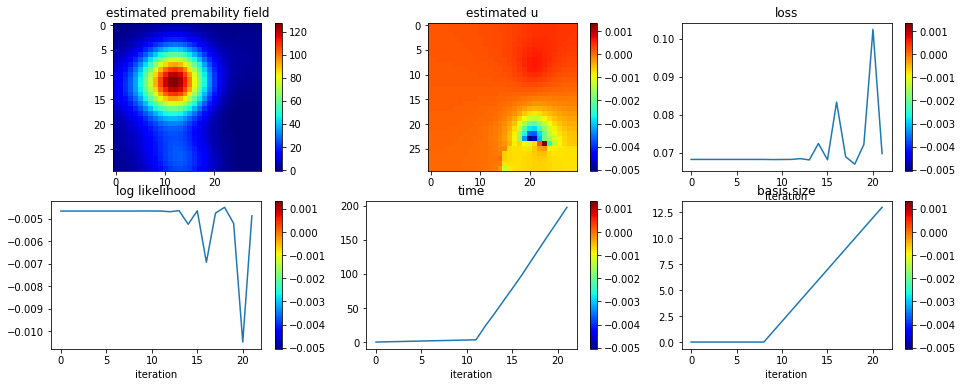

iter: 22
u_loss: 0.06974251391751654, x_loss: 126.43116016774692
average acceptance level: 1.0
basis size: 13
full model evaluations: 22
cummulative_time: 197.4115149999634
last x: [  1.94965333  10.64919143   2.54397117 125.59069918  -2.41613
  23.05511148  11.94746847   2.17400833  -0.92707699]
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


KeyboardInterrupt: 

In [11]:
alg = alg2()
alg(eps=1e-3, N_verbose=3, N_maxiter=300)
alg.print_best()

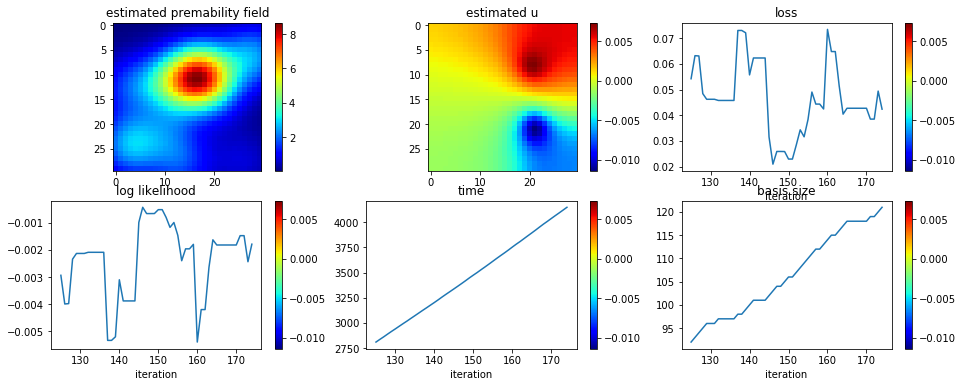

iter: 175
u_loss: 0.04235599914141904, x_loss: 11.534185820213219
average acceptance level: 0.8905575860627643
basis size: 121
full model evaluations: 142
cummulative_time: 4148.996521000032
last x: [2.60649281 1.13287184 6.58542823 3.5682299  0.67958593 1.47542726
 1.55747472 2.36188477 0.69717714]
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time

KeyboardInterrupt: 

In [14]:
alg = alg2()
alg(eps=1e-2, N_verbose=3, N_maxiter=300)
alg.print_best()

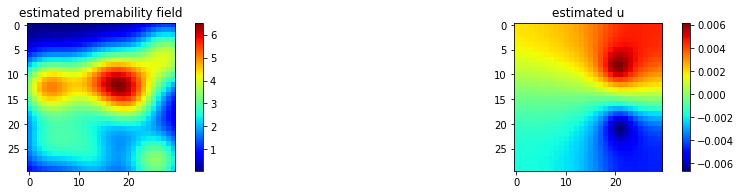

best iter: 27
average acceptance level: 0.8914546550294629
basis size: 23
full model evaluations: 25
u_loss: 0.014481094711868278, x_loss: 8.269150124573711
cummulative_time: 481.0950820000053


In [15]:
alg.print_best()

In [ ]:
alg

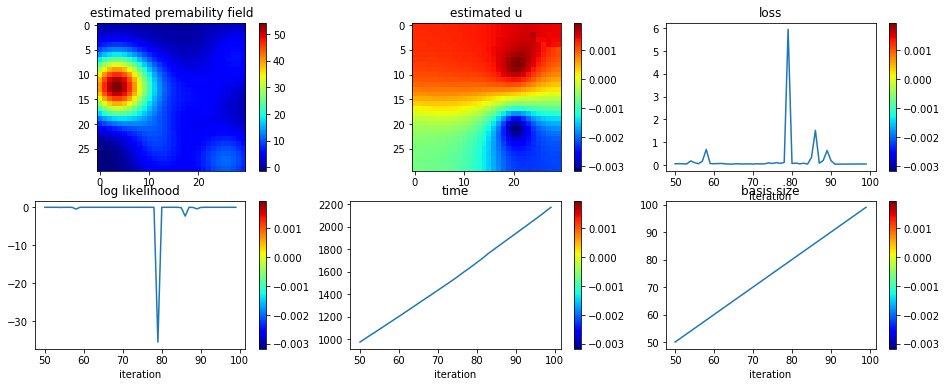

iter: 100
u_loss: 0.04494586909085383, x_loss: 50.87207218459635
average acceptance level: 1.0
basis size: 99
full model evaluations: 100
cummulative_time: 2175.019356999971
last x: [-2.64698261  7.82447758  0.1097043   5.20494795  4.77272423  4.17081585
 53.85282832  6.16274072 11.21878724]
----------------------------------------


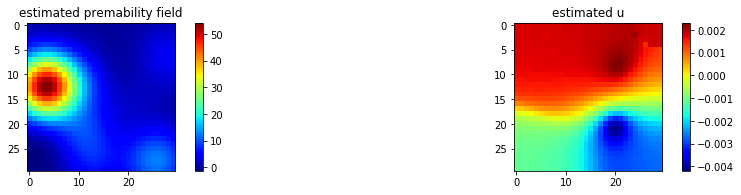

best iter: 94
average acceptance level: 1.0
basis size: 93
full model evaluations: 94
u_loss: 0.03748972623801183, x_loss: 51.40981396837458
cummulative_time: 2017.8908649999585


In [8]:
alg = alg2()
alg(eps=1e-1, N_verbose=3)
alg.print_best()

# alg2 

In [10]:
class alg3:
    def __init__(self, from_log=False, eps=1e-3):
        self.x_loss = []
        self.u_loss = []
        self.x_i = []
        self.times = [] # appended on each iteration, regardless the acceptance
        self.acceptance_betas = []
        self.log_likelihoods = []
        self.n_basis = []
        self.full_evals = []
        
        if from_log:
            with open(f'alg2v2_eps{eps:.4f}_log.pkl', 'rb') as f:
                data = pickle.load(f)
                self.x_loss = data['x_loss'] 
                self.u_loss = data['u_loss'] 
                self.x_i = data['x_i'] 
                self.times = data['times'] # appended on each iteration, regardless the acceptance
                self.acceptance_betas = data['acceptance_betas'] 
                self.log_likelihoods = data['log_likelihoods'] 
                self.n_basis = data['n_basis'] 
                self.full_evals = data['full_evals']
    
    def __call__(self, task=task, sigma_q=0.005, sigma0=2, sigma_d=1., eps=1e-3, eps0=None, x=None, N_maxiter=100, L=50, c=1e-1, N_verbose=1):
        if eps0 is None:
            eps0=eps*5
        len_min=2
        
        if x is None:
            x = np.random.lognormal(mean=.0, sigma=sigma0, size=task.n_p)
        q = partial(normal_sampler, sigma=sigma_q)

        full_counter = 0
        snapshots = []
        error_rows = []
        time = 0
        u_last, _ = task.evaluate(x)
        for i in range(N_maxiter):
            x_new = q(x)
            u, dt1 = task.evaluate(x_new)
            
            if len(snapshots) > len_min:
                u_m, dt2 = task.basis_projection_solution(x_new, snapshots, u)
                t_m = t_cond(task.u, u_m, sigma_d)
            if len(snapshots) <= len_min or t_m > eps0:
                time += dt1
                full_counter += 1
                pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
                beta = min(1, pi(x_new)/(pi(x) + 1e-10))
                if np.random.rand() < beta:
                    self.acceptance_betas.append(beta)
                    x = x_new
                    snapshots.append(u)
                    u_last = u
            elif t_m > eps:
                time += dt2
                pi_m = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
                beta = min(1, pi_m(x_new)/(pi_m(x) + 1e-10))
                if np.random.rand() < beta:
                    time += dt1
                    full_counter += 1
                    pi = partial(posterior, F=u, d_obs=task.u, prior=prior, sigma=sigma_d)
                    beta = min(1, pi(x_new)/(pi(x) + 1e-10))
                    if np.random.rand() < beta:
                        self.acceptance_betas.append(beta)
                        x = x_new
                        snapshots.append(u)
                        u_last = u
            else:
                pi_m = partial(posterior, F=u_m, d_obs=task.u, prior=prior, sigma=sigma_d)
                beta = min(1, pi_m(x_new)/(pi_m(x) + 1e-10))
                if np.random.rand() < beta:
                    self.acceptance_betas.append(beta)
                    x = x_new
#                     snapshots.append(u)
                    u_last = u_m
                
            self.x_i.append(x)
            self.n_basis.append(len(snapshots))
            self.x_loss.append(np.linalg.norm(task.x - self.x_i[-1]))
            self.u_loss.append(np.linalg.norm(task.u - u_last))
            self.log_likelihoods.append(np.log(likelihood(x, u_last, task.u, sigma_d)))
            self.times.append(time)
            self.full_evals.append(full_counter)

            K = task.eval_perm_field(x)

            with open(f'alg2v2_eps{eps:.4f}_log.pkl', 'wb') as f:
                pickle.dump({
                    'x_loss': self.x_loss,
                    'u_loss': self.u_loss,
                    'x_i': self.x_i,
                    'times': self.times,
                    'acceptance_betas': self.acceptance_betas,
                    'log_likelihoods': self.log_likelihoods,
                    'n_basis': self.n_basis,
                    'full_evals': self.full_evals,
                }, f)

            if i % N_verbose == 0:
                clear_output()
                plt.rcParams['figure.figsize'] = (16,6)
                plt.subplot(231); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
                plt.subplot(232); plt.imshow(u_last, cmap='jet'); plt.title('estimated u'); plt.colorbar()
                lastN = 50
                plt.subplot(233); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.u_loss[-lastN:]); plt.title('loss'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(234); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.log_likelihoods[-lastN:]); plt.title('log likelihood'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(235); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.times[-lastN:]); plt.title('time'); plt.xlabel('iteration'); plt.colorbar()
                plt.subplot(236); plt.plot(np.arange(max(i-lastN+1, 0), i+1), self.n_basis[-lastN:]); plt.title('basis size'); plt.xlabel('iteration'); plt.colorbar()
                plt.show()
                print(f'iter: {i+1}')
                print(f'u_loss: {self.u_loss[-1]}, x_loss: {self.x_loss[-1]}')
                print(f'average acceptance level: {np.mean(self.acceptance_betas)}')
                print(f'basis size: {self.n_basis[-1]}')
                print(f'full model evaluations: {self.full_evals[-1]}')
                print(f'cummulative_time: {self.times[-1]}')
                print(f'last x: {self.x_i[-1]}')
                print('-'*40)
                
    def print_best(self):
        ind_best = np.argmax(self.log_likelihoods)
        x_best = self.x_i[ind_best]
        K = task.eval_perm_field(x_best) 
        u, _ = task.evaluate(x_best)
        plt.subplot(221); plt.imshow(K, cmap='jet'); plt.title('estimated premability field'); plt.colorbar()
        plt.subplot(222); plt.imshow(u, cmap='jet'); plt.title('estimated u'); plt.colorbar()
        plt.show()
        print(f'best iter: {ind_best + 1}')
        print(f'average acceptance level: {np.mean(self.acceptance_betas)}')
        print(f'basis size: {self.n_basis[ind_best]}')
        print(f'full model evaluations: {self.full_evals[ind_best]}')
        print(f'u_loss: {self.u_loss[ind_best]}, x_loss: {self.x_loss[ind_best]}')
        print(f'cummulative_time: {self.times[ind_best]}')

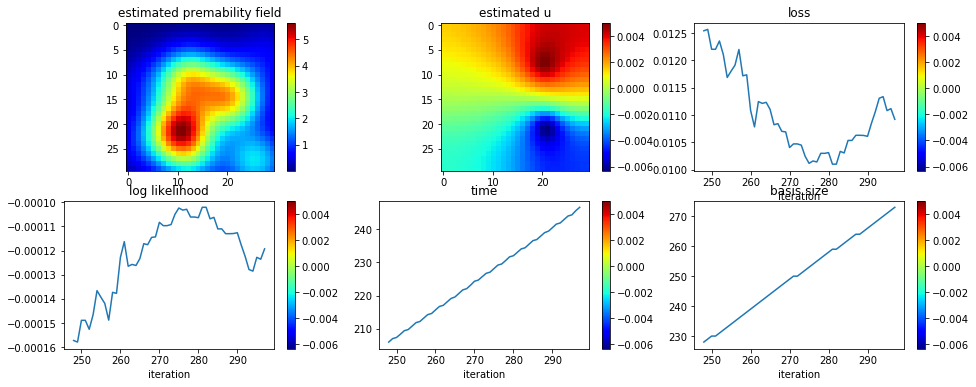

iter: 298
u_loss: 0.010922340263570574, x_loss: 7.243533690154577
average acceptance level: 0.9388999845759439
basis size: 273
full model evaluations: 298
cummulative_time: 246.67240100003255
last x: [0.56414115 4.96394755 0.26677756 3.30011322 3.63200124 1.00272688
 0.50234685 0.56798977 1.95151473]
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


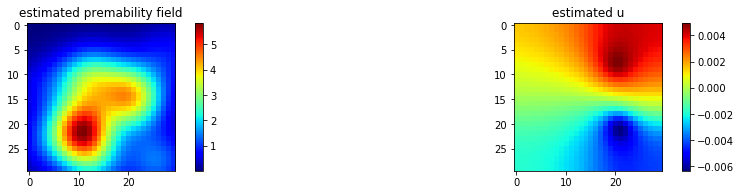

best iter: 185
average acceptance level: 0.9393443483244825
basis size: 168
full model evaluations: 185
u_loss: 0.009801550027836675, x_loss: 6.978881375543178
cummulative_time: 151.39452800001163


In [24]:
alg = alg3()
alg(eps=1e-1, sigma_q=0.001, eps0=9e-3, N_verbose=3, N_maxiter=300)
alg.print_best()

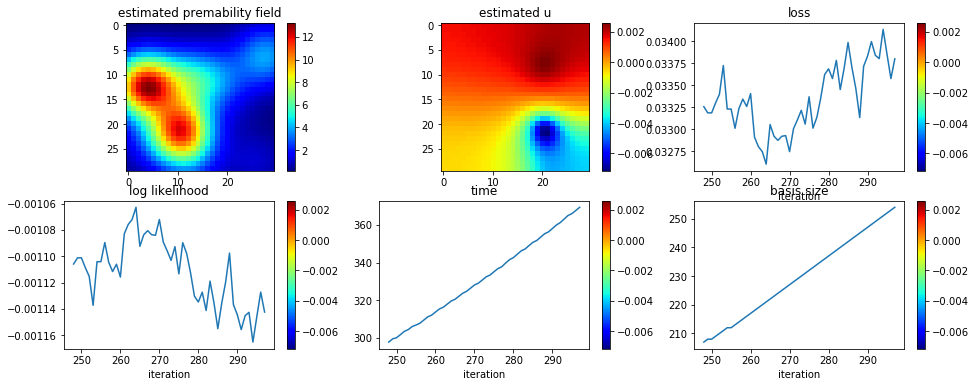

iter: 298
u_loss: 0.033800521392956084, x_loss: 13.825562162486982
average acceptance level: 0.9506616426960801
basis size: 254
full model evaluations: 276
cummulative_time: 369.361293000009
last x: [ 0.89382895 11.034706    2.28773669  4.03518628  0.69115157  1.31170408
 12.23212061  3.84122708  1.06031617]
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


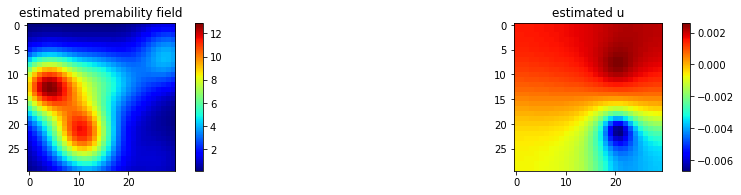

best iter: 265
average acceptance level: 0.9507929363762541
basis size: 221
full model evaluations: 243
u_loss: 0.03260010037647483, x_loss: 13.129457916490631
cummulative_time: 319.5390069999994


In [24]:
alg = alg3()
alg(eps=1e-2, N_verbose=3, N_maxiter=300)
alg.print_best()

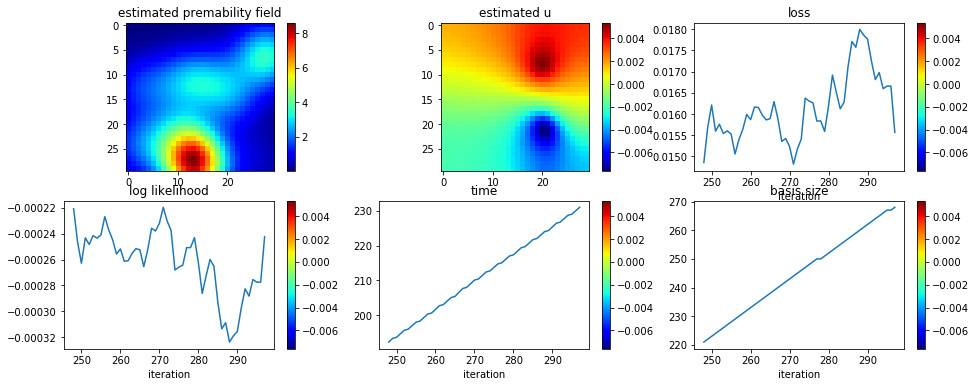

iter: 298
u_loss: 0.015566001283344767, x_loss: 11.232101935488528
average acceptance level: 0.9407017704159925
basis size: 268
full model evaluations: 298
cummulative_time: 230.9636180000016
last x: [1.75367036 1.85966373 1.13470654 2.21553026 1.74476672 7.93024484
 1.42208616 3.42246338 0.5356657 ]
----------------------------------------
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


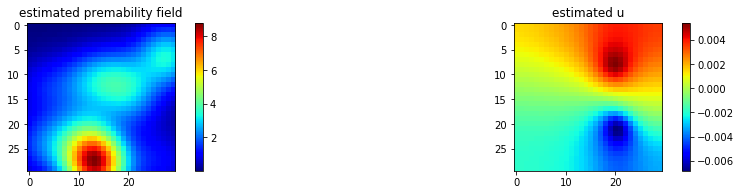

best iter: 233
average acceptance level: 0.9409126989365332
basis size: 206
full model evaluations: 233
u_loss: 0.01407958753066649, x_loss: 11.435227024187947
cummulative_time: 179.09824299999673


In [28]:
alg = alg3()
alg(eps=1e-3, N_verbose=3, N_maxiter=300)
alg.print_best()